# Covid-19: From model prediction to model predictive control

## Calibration of the age-stratified deterministic model

*Original code by Ryan S. McGee. Modified by T.W. Alleman in consultation with the BIOMATH research unit headed by prof. Ingmar Nopens.*

Copyright (c) 2020 by T.W. Alleman, BIOMATH, Ghent University. All Rights Reserved.

This notebook accompanies our preprint: "*A deterministic, age-stratified, extended SEIRD model for assessing the effect of non-pharmaceutical interventions on SARS-CoV-2 spread in Belgium*"(https://doi.org/10.1101/2020.07.17.20156034)

### Load required packages

In [1]:
import random
import os
import numpy as np
import json
import corner
import random

import pandas as pd
import datetime
import scipy
import matplotlib.dates as mdates
import matplotlib
import math
import xarray as xr
import emcee
import matplotlib.pyplot as plt

from covid19model.optimization import objective_fcns
from covid19model.optimization import MCMC
from covid19model.models import models
from covid19model.data import google
from covid19model.data import sciensano
from covid19model.data import polymod
from covid19model.data import parameters
from covid19model.visualization.output import population_status, infected
from covid19model.visualization.optimization import plot_fit, traceplot

# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

### Load interaction matrices

In [2]:
initN, Nc_home, Nc_work, Nc_schools, Nc_transport, Nc_leisure, Nc_others, Nc_total = polymod.get_interaction_matrices()
levels = initN.size

### Initialize the model

In [3]:
# Load the parameters using `get_COVID19_SEIRD_parameters()`.
params = parameters.get_COVID19_SEIRD_parameters()
# Add the delayed ramp parameters to the parameter dictionary.
params.update({'l': 1,
              'tau': 5})
# Define the initial condition: one exposed inidividual in every age category
initial_states = {'S': initN, 'E': np.ones(levels)}
# Load the compliance model
from covid19model.models.compliance import ramp_2
# Initialize the model
model = models.COVID19_SEIRD(initial_states, params, compliance=ramp_2)

### Scrape high-level Sciensano data

In [4]:
df_sciensano = sciensano.get_sciensano_COVID19_data(update=False)
df_sciensano.tail()

,H_tot,ICU_tot,H_in,H_out,H_tot_cumsum,D_tot,D_25_44,D_45_64,D_65_74,D_75_84,D_85+
DATE,,,,,,,,,,,
2020-08-06,278,65,28,39,687,2,0.0,0.0,0,1.0,1
2020-08-07,285,69,27,28,686,4,0.0,0.0,0,1.0,3
2020-08-08,281,67,31,39,678,2,0.0,0.0,0,2.0,0
2020-08-09,285,69,20,14,684,4,1.0,0.0,0,1.0,2
2020-08-10,312,73,33,12,705,3,0.0,1.0,1,0.0,1


### Calibrating $\beta$ and lag_time

**Go to next section if posterior samples are available**

Use the function `fit_pso` to obtain a good starting estimate for the MCMC sampler.

In [5]:
# define dataset
data=[df_sciensano["H_in"].values[:8]]
# set optimisation settings
parNames = ['sigma_H_in','extraTime','beta'] # must be a list!
states = [["H_in"]]
bounds=((1,100),(30,60),(0.02,0.06)) # must be a list!
# run optimisation
theta = MCMC.fit_pso(model,data,parNames,states,bounds,maxiter=50,popsize=50)

No constraints given.


TypeError: 'NoneType' object is not subscriptable

In [6]:
lag_time = int(round(theta[1]))
# Assign 'extraTime' or lag_time as a model attribute --> is needed to perform the optimalization
model.extraTime = int(round(theta[1]))
# Date of first data collection
start_date = '15-03-2020'

Initiatize and run the MCMC sampler

In [11]:
parNames = ['sigma_ICU','beta'] # must be a list!
bounds=((1,200),(0.01,0.10))
# Initialise starting position of sampler based on PSO estimate
pos = [theta[0],theta[2]] + [1, 1e-2 ]* np.random.randn(4, 2)
nwalkers, ndim = pos.shape
sampler = emcee.EnsembleSampler(nwalkers, ndim, objective_fcns.log_probability,
                                args=(model,bounds,data,states,parNames))
sampler.run_mcmc(pos, 300, progress=True);

100%|██████████| 300/300 [00:44<00:00,  6.72it/s]


In [12]:
samples = sampler.get_chain(discard=100,flat=False)
flat_samples = sampler.get_chain(discard=100,flat=True)

In [13]:
# Calculate the autocorrelation time
sampler.get_autocorr_time()

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 6;
tau: [20.03503137 14.79106322]

In [14]:
# Calculate mean, percentile 10 and percentile 90 of samples
# index 1 = beta
print(np.mean(flat_samples[:,1]),np.percentile(flat_samples[:,1],10),np.percentile(flat_samples[:,1],90))

0.036842829344261536 0.036594545494788314 0.03712191600200329


Initialize a dictionary with the posterior samples and write them to `parameters_deterministic.json`

In [15]:
samples_dict={'lag_time': int(round(theta[1])), 'beta': flat_samples[:,1].tolist()}

In [16]:
with open('parameters_deterministic.json', 'w') as fp:
    json.dump(samples_dict, fp)

Make a traceplot and cornerplot of the posterior samples

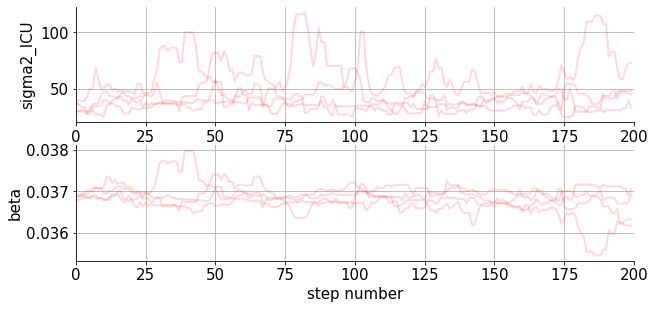

In [17]:
traceplot(samples,labels=["sigma2_ICU","beta"],plt_kwargs={'linewidth':2,'color': 'red','alpha': 0.15})

NameError: name 'plt' is not defined

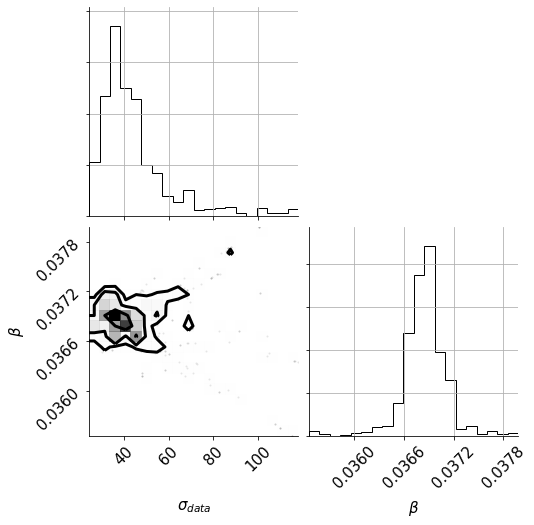

In [18]:
fig = corner.corner(
    flat_samples,labels=['$\sigma_{data}$','$\\beta$']
);
fig.set_size_inches(8, 8)
plt.savefig('corner_beta.pdf', dpi=600, bbox_inches='tight',
                    orientation='portrait', papertype='a4')

Make a visualisation of the data and model prediction

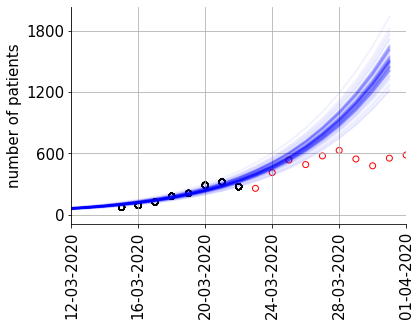

In [21]:
T = 9
fig,ax=plt.subplots()

for i in range(100):
    model.parameters['beta'] = np.random.choice(samples_dict['beta'],1,replace=False)
    y_model = model.sim(data[0].size+lag_time-1+T)
    ax = plot_fit(y_model,data,start_date,lag_time,states,T=T,ax=ax,plt_kwargs={'color':'blue','linewidth': 2,'alpha': 0.05})

plt.scatter(pd.date_range('15-03-2020',freq='D',periods=df_sciensano["H_in"][8:18].size)+datetime.timedelta(days=data[0].size),df_sciensano["H_in"][8:18], marker='o',color='red',linestyle='None',facecolors='none')
plt.savefig('plot_fit_beta.pdf', dpi=600, bbox_inches='tight',orientation='portrait', papertype='a4')

### Calibrating the compliance ramp parameters

Load the previously calibrated parameters.

In [22]:
with open('parameters_deterministic.json', 'r') as fp:
    samples_dict = json.load(fp)

lag_time = samples_dict['lag_time']
model.extraTime = samples_dict['lag_time']
model.parameters['beta'] = np.mean(samples_dict['beta'])

In [23]:
samples_beta = {'beta': samples_dict['beta']}

Find an initial guess for the MCMC sampler by using PSO

In [24]:
# Create checkpoints dictionary
# NOTE: this checkpoints dictionary is actually a dummy! The checkpoints are HARDCODED in the objective function `MLE`
chk = {'time':  [lag_time], 
       'Nc':    [prevention*(1.0*Nc_home + (1-0.60)*Nc_work + (1-0.70)*Nc_transport + (1-0.30)*Nc_others + (1-0.80)*Nc_leisure)],
      }
# define dataset
data=[df_sciensano["H_in"].values[:37]]
# set optimisation settings
parNames = ['sigma_H_in','l','tau','prevention'] # must be a list!
states = [["H_in"]]
bounds=((1,100),(0.1,20),(0,20),(0,1)) # must be a list!
# run optimisation
theta = MCMC.fit_pso(model,data,parNames,states,bounds,checkpoints=chk,samples=samples_beta,maxiter=20,popsize=10)

No constraints given.
New best for swarm at iteration 1: [95.38227157 13.00531876  0.          0.        ] 221.47070953125473
Best after iteration 1: [95.38227157 13.00531876  0.          0.        ] 221.47070953125473
New best for swarm at iteration 2: [100.  20.   0.   0.] 188.93497226870952
Best after iteration 2: [100.  20.   0.   0.] 188.93497226870952
Best after iteration 3: [100.  20.   0.   0.] 188.93497226870952
New best for swarm at iteration 4: [100.           9.25518473   0.           0.44549655] 183.54556465014792
Best after iteration 4: [100.           9.25518473   0.           0.44549655] 183.54556465014792
Best after iteration 5: [100.           9.25518473   0.           0.44549655] 183.54556465014792
New best for swarm at iteration 6: [100.           9.25629267   0.           0.44035473] 183.25559581057306
Best after iteration 6: [100.           9.25629267   0.           0.44035473] 183.25559581057306
Best after iteration 7: [100.           9.25629267   0.           0.

In [22]:
model.parameters.update({
    'l': theta[1],
    'tau': theta[2]

}
)
prevention = theta[3]

Initialize and run the MCMC sampler

In [25]:
bounds=((1,100),(0.001,20),(0,20),(0,1)) # must be a list!
pos = theta + [1, 0.1, 0.1, 0.1 ]* np.random.randn(8, 4)
nwalkers, ndim = pos.shape
sampler = emcee.EnsembleSampler(nwalkers, ndim, objective_fcns.log_probability,
                                args=(model,bounds,data,states,parNames,chk,samples_beta))
sampler.run_mcmc(pos, 300, progress=True);

  0%|          | 0/300 [00:00<?, ?it/s]/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 300/300 [02:11<00:00,  2.28it/s]


In [26]:
sampler.get_autocorr_time()

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 6;
tau: [40.12840894 40.0747126  40.38656577 25.15164865]

In [27]:
samples = sampler.get_chain(discard=200,flat=False)
flat_samples = sampler.get_chain(discard=200,flat=True)

Append posterior samples to the samples dictionary

In [28]:
samples_dict.update({'l': flat_samples[:,1].tolist(),'tau':flat_samples[:,2].tolist(),'prevention':flat_samples[:,3].tolist()})

In [29]:
with open('parameters_deterministic.json', 'w') as fp:
    json.dump(samples_dict, fp)

In [30]:
# Calculate mean, percentile 10 and percentile 90 of samples
# index 0 --> sigma_{data}
# index 3 --> prevention
print(np.mean(flat_samples[:,1]),np.percentile(flat_samples[:,1],10),np.percentile(flat_samples[:,1],90))

3.4557876417738136 0.4956830994658947 7.375258661975575


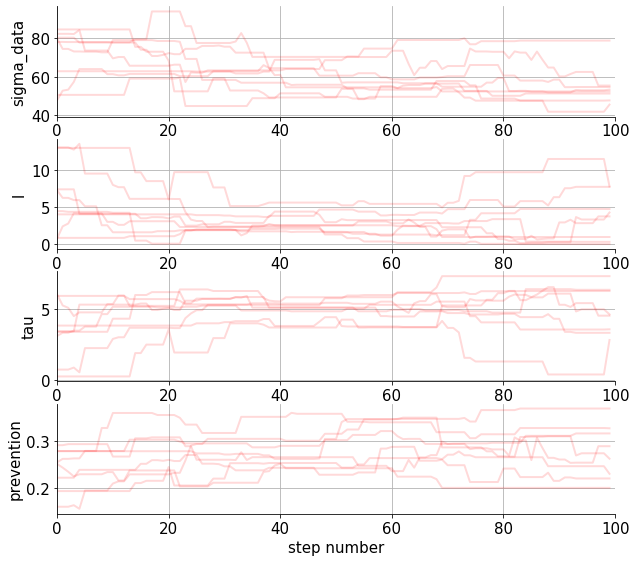

In [31]:
traceplot(samples=sampler.get_chain(discard=200),labels=["sigma_data","l","tau","prevention"],plt_kwargs={'linewidth':2,'color': 'red','alpha': 0.15})

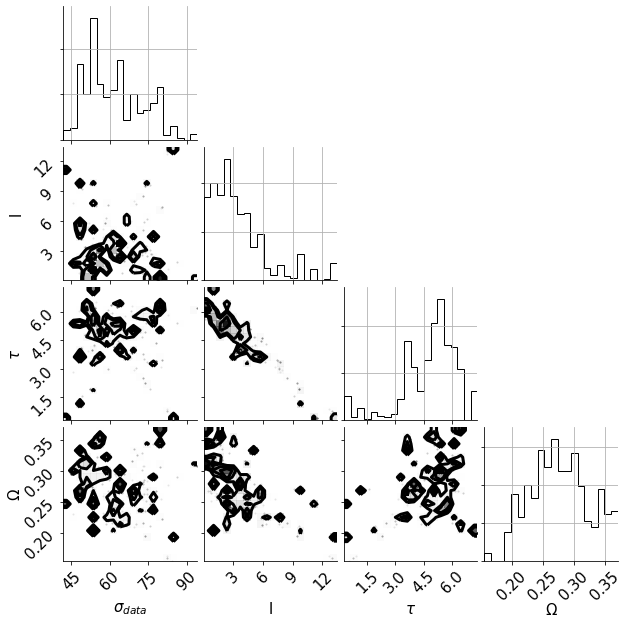

In [32]:
fig = corner.corner(
    flat_samples, labels=["$\sigma_{data}$","l","$\\tau$","$\Omega$"],
);
fig.set_size_inches(9, 9)
plt.savefig('corner_compliance_delayed_ramp.pdf', dpi=600, bbox_inches='tight',
                    orientation='portrait', papertype='a4')

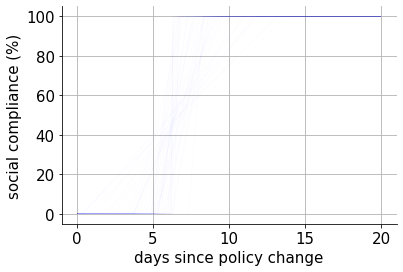

In [33]:
fig,ax=plt.subplots()
t = np.linspace(0,20,400)
for i in range(100):
    idx,l= random.choice(list(enumerate(flat_samples[:,1])))
    tau = samples_dict['tau'][idx]
    y=[]
    for j in range(len(t)):
        y.append(100*ramp_2(t[j],0,1,l,tau))
    ax.plot(t,y,color='blue',linewidth=0.1,alpha=0.05)
ax.set_xlabel('days since policy change')
ax.set_ylabel('social compliance (%)')
plt.savefig('compliance_delayed_ramp.pdf', dpi=600, bbox_inches='tight',orientation='portrait', papertype='a4')

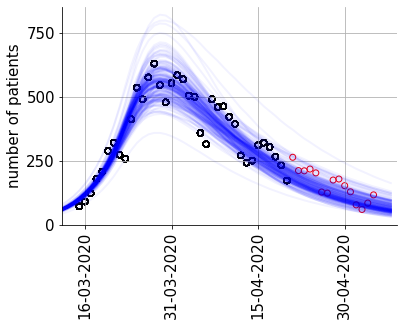

In [34]:
T = 18
start_date = '15-03-2020'
fig,ax=plt.subplots()
for i in range(200):
    idx,model.parameters['beta'] = random.choice(list(enumerate(samples_dict['beta'])))
    idx,model.parameters['l'] = random.choice(list(enumerate(flat_samples[:,1])))
    model.parameters['tau'] = samples_dict['tau'][idx]
    prevention = samples_dict['prevention'][idx]
    # Create a dictionary of past policies
    chk = {'time':   [lag_time], 
          'Nc':      [prevention*(1.00*Nc_home + (1-0.60)*Nc_work + (1-0.70)*Nc_transport + (1-0.30)*Nc_others + (1-0.80)*Nc_leisure)]
          }
    y_model = model.sim(data[0].size+lag_time-1+T,checkpoints=chk)
    ax = plot_fit(y_model,data,start_date,lag_time,states,T=T,ax=ax,plt_kwargs={'color':'blue','linewidth': 2,'alpha': 0.05})

plt.scatter(pd.date_range('15-03-2020',freq='D',periods=df_sciensano["H_in"][37:52].size)+datetime.timedelta(days=data[0].size),df_sciensano["H_in"][37:52], marker='o',color='red',linestyle='None',facecolors='none')
legend_text=['daily \nhospitalizations']
#leg=ax.legend(legend_text, loc="upper left", bbox_to_anchor=(1,1))
ax.set_ylim([0,850])
plt.savefig('plot_fit_compliance.pdf', dpi=600, bbox_inches='tight',orientation='portrait', papertype='a4')

### Computation of the basic reproduction number

2.8606658225683534 2.8326450825022675 2.888289530593747


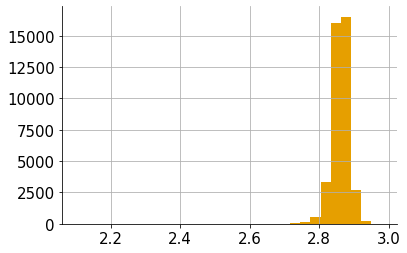

In [16]:
R_0 =[]
for i in range(len(samples_dict['beta'])):
    R_0.append(sum((model.parameters['a']*model.parameters['da']+model.parameters['omega'])*samples_dict['beta'][i]*model.parameters['s']*np.sum(Nc_total,axis=1)*(initN/sum(initN))))

plt.hist(R_0,bins=30)
mean = np.mean(R_0)
p10 = np.percentile(R_0,10)
p90 = np.percentile(R_0,90)
print(mean,p10,p90)

1.6371595958661558 1.6211233209819833 1.6529686492377154
2.0056305846013673 1.9859850696179884 2.0249977379538295
4.414393932051874 4.371154143627976 4.457021046385204
5.177462245653499 5.126748064834861 5.227457846068659
4.068346953429086 4.028496757862258 4.107632502793474
2.9883170100032928 2.959045903426717 3.0171733678205563
1.4771816171230114 1.4627123555275965 1.4914458605624112
0.8366881225845482 0.8284926108213906 0.844767510335558
0.9272265339806824 0.9181441820729287 0.9361801960428541


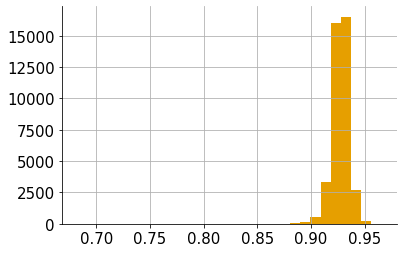

In [17]:
R_0 = np.zeros([initN.size,len(samples_dict['beta'])])
for i in range(len(samples_dict['beta'])):
    R_0[:,i]= (model.parameters['a']*model.parameters['da']+model.parameters['omega'])*samples_dict['beta'][i]*model.parameters['s']*np.sum(Nc_total,axis=1)
plt.hist(R_0[8,:],bins=30)

for i in range(R_0.shape[0]):
    mean = np.mean(R_0[i,:])
    p10 = np.percentile(R_0[i,:],10)
    p90 = np.percentile(R_0[i,:],90)
    print(mean,p10,p90)

### Visualisations used in the preprint

Load the posterior samples

In [8]:
with open('../data/interim/model_parameters/deterministic_22072020.json', 'r') as fp:
    samples_dict = json.load(fp)

lag_time = samples_dict['lag_time']
model.extraTime = samples_dict['lag_time']
model.parameters['beta'] = np.mean(samples_dict['beta'])
model.parameters['l'] = np.mean(samples_dict['l'])
model.parameters['tau'] = np.mean(samples_dict['tau'])
prevention = np.mean(samples_dict['prevention'])

#### Cumulative hospitalizations

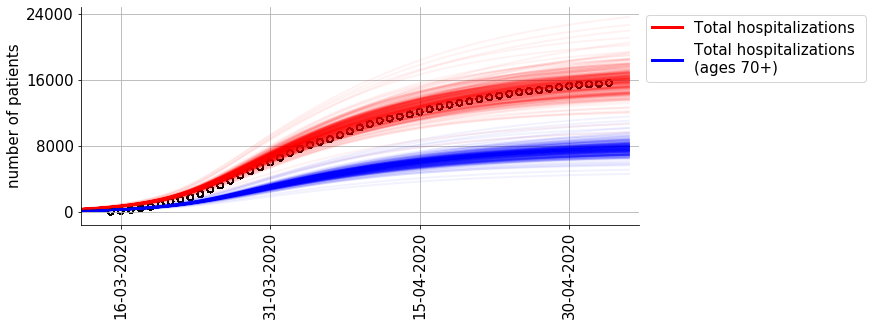

In [35]:
from covid19model.visualization.output import _apply_tick_locator

# define dataset
data=[df_sciensano["H_in"].values[:51]]
states = [["H_in"]]
start_date = '15-03-2020'

T = 2

fig,ax=plt.subplots()
for i in range(300):
    model.parameters['beta'] = np.random.choice(samples_dict['beta'],1,replace=False)
    idx,model.parameters['l'] = random.choice(list(enumerate(samples_dict['l'])))
    model.parameters['tau'] = samples_dict['tau'][idx]
    prevention = samples_dict['prevention'][idx]
    # Create a dictionary of past policies
    chk = {'time':   [lag_time], 
          'Nc':      [prevention*(1.0*Nc_home + (1-0.60)*Nc_work + (1-0.70)*Nc_transport + (1-0.30)*Nc_others + (1-0.80)*Nc_leisure)]
          }
    y_model = model.sim(data[0].size+lag_time-1+T,checkpoints=chk)
    
    # Create shifted index vector 
    idx = pd.date_range(start_date,freq='D',periods=data[0].size + lag_time + T) - datetime.timedelta(days=lag_time)
    # Plot model prediction

    lines = ax.plot([],[],color='red',alpha=1)
    lines = ax.plot([],[],color='blue',alpha=1)
    
    for i in range(len(data)):
        # ages 60 plus
        #data2plot = y_model[states[i]].to_array(dim="states").values.ravel()
        #val = y_model[states[i]].to_array(dim="states").values[:,6:,:].sum(axis=1)
        #csum=np.cumsum(val)
        #lines = ax.plot(idx,csum,color='green',linewidth= 2,alpha= 0.05)    
        # ages 70 plus
        data2plot = y_model[states[i]].to_array(dim="states").values.ravel()
        val = y_model[states[i]].to_array(dim="states").values[:,7:,:].sum(axis=1)
        csum=np.cumsum(val)
        lines = ax.plot(idx,csum,color='blue',linewidth= 2,alpha= 0.05)    
        # total cumsum
        data2plot = y_model[states[i]].to_array(dim="states").values.ravel()
        val = y_model[states[i]].to_array(dim="states").values.sum(axis=1)
        csum=np.cumsum(val)
        lines = ax.plot(idx,csum,color='red',linewidth= 2,alpha= 0.05)  
    # Plot data
    for i in range(len(data)):
        lines=ax.scatter(idx[lag_time:-T],np.cumsum(data[i]),color="black",facecolors='none')
    
    # Format axes
    ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
    plt.setp(plt.gca().xaxis.get_majorticklabels(),
        'rotation', 90)
    #fig.autofmt_xdate(rotation=90)
    ax.set_xlim( idx[lag_time-3], pd.to_datetime(idx[-1]+ datetime.timedelta(days=1)))
    ax.set_ylabel('number of patients')

    # limit the number of ticks on the axis
    ax = _apply_tick_locator(ax)

legend_text=['Total hospitalizations','Total hospitalizations \n(ages 70+)']
leg=ax.legend(legend_text, loc="upper left", bbox_to_anchor=(1,1))
for lh in leg.get_lines(): 
    lh.set_alpha(1)
fig.set_size_inches(10, 4)
plt.savefig('hospital_age.pdf', dpi=300, bbox_inches='tight',orientation='portrait', papertype='a4')

#### Lockdown release

In [42]:
data=[df_sciensano["H_tot"].values[:],df_sciensano["ICU_tot"].values[:]]
states = [["H_tot"],["ICU"]]

In [43]:
T = 62
# Define data as a list containing data timeseries
index = pd.date_range('15-03-2020',freq='D',periods=data[0].size + lag_time + T)
print(index[1],index[50],index[52],index[57],index[64],index[81],index[108],index[170])

2020-03-16 00:00:00 2020-05-04 00:00:00 2020-05-06 00:00:00 2020-05-11 00:00:00 2020-05-18 00:00:00 2020-06-04 00:00:00 2020-07-01 00:00:00 2020-09-01 00:00:00


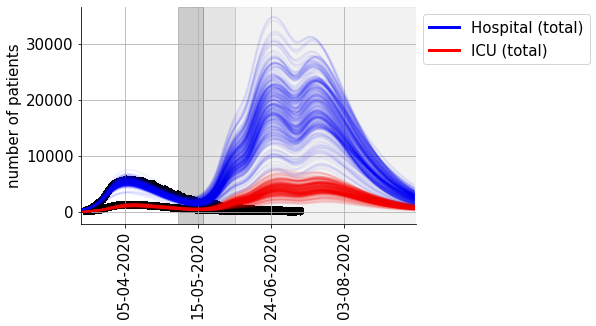

In [44]:
T = 62

fig,ax=plt.subplots()

ax.axvspan(index[50], index[64], alpha=0.20, color='black')
ax.axvspan(index[64], index[81], alpha=0.10, color='black')
ax.axvspan(index[81], index[-1], alpha=0.05, color='black')

for i in range(300):
    model.parameters['beta'] = np.random.choice(samples_dict['beta'],1,replace=False)
    idx,model.parameters['l'] = random.choice(list(enumerate(samples_dict['l'])))
    model.parameters['tau'] = samples_dict['tau'][idx]
    prevention = samples_dict['prevention'][idx]
    # Create a dictionary of past policies
    chk = {'time':   [lag_time,lag_time+50,lag_time+52,lag_time+57,lag_time+64,lag_time+81,lag_time+108], 
          'Nc':      [prevention*(1.0*Nc_home + (1-0.60)*Nc_work + (1-0.70)*Nc_transport + (1-0.30)*Nc_others + (1-0.80)*Nc_leisure),
                      prevention*(1.0*Nc_home + (1-0.50)*Nc_work + (1-0.60)*Nc_transport + (1-0.30)*Nc_others + (1-0.70)*Nc_leisure),
                      prevention*(1.0*Nc_home + (1-0.40)*Nc_work + (1-0.55)*Nc_transport + (1-0.25)*Nc_others + (1-0.65)*Nc_leisure),
                      prevention*(1.0*Nc_home + (1-0.30)*Nc_work + (1-0.50)*Nc_transport + (1-0.20)*Nc_others + (1-0.60)*Nc_leisure),
                      prevention*(1.0*Nc_home + (1-0.30)*Nc_work + (1-0.45)*Nc_transport + (1-0.85)*Nc_schools + (1-0.15)*Nc_others + (1-0.50)*Nc_leisure),
                      prevention*(1.0*Nc_home + (1-0.25)*Nc_work + (1-0.35)*Nc_transport + (1-0.35)*Nc_schools + (1-0.10)*Nc_others + (1-0.30)*Nc_leisure),
                      prevention*(1.0*Nc_home + (1-0.20)*Nc_work + (1-0.15)*Nc_transport + (1-0.00)*Nc_others + (1-0.00)*Nc_leisure)]
                  }
    y_model = model.sim(data[0].size+lag_time-1+T,checkpoints=chk)
    ax = plot_fit(y_model,data,'15-03-2020',lag_time,states,T=T,ax=ax,
                  legend_text=None,
                  plt_kwargs={'linewidth': 2,'alpha': 0.05})

legend_text=['Hospital (total)','ICU (total)']
leg=ax.legend(legend_text, loc="upper left", bbox_to_anchor=(1,1))
for lh in leg.get_lines(): 
    lh.set_alpha(1)
plt.savefig('lockdown_release.pdf', dpi=300, bbox_inches='tight',orientation='portrait', papertype='a4')

#### Continuation of lockdown

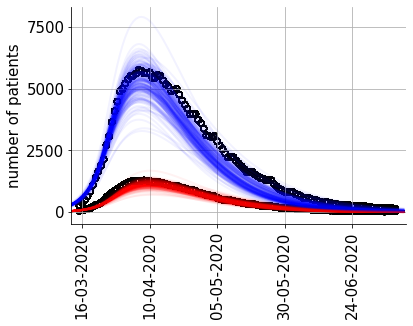

In [45]:
T = 3

fig,ax=plt.subplots()

for i in range(200):
    model.parameters['beta'] = np.random.choice(samples_dict['beta'],1,replace=False)
    idx,model.parameters['l'] = random.choice(list(enumerate(samples_dict['l'])))
    model.parameters['tau'] = samples_dict['tau'][idx]
    prevention = samples_dict['prevention'][idx]
    # Create a dictionary of past policies
    chk = {'time':   [lag_time], 
          'Nc':      [prevention*(1.0*Nc_home + (1-0.60)*Nc_work + (1-0.70)*Nc_transport + (1-0.30)*Nc_others + (1-0.80)*Nc_leisure),
                     ]
                  }
    y_model = model.sim(data[0].size+lag_time-1+T,checkpoints=chk)
    ax = plot_fit(y_model,data,'15-03-2020',lag_time,states,T=T,ax=ax,
                  legend_text=None,
                  plt_kwargs={'linewidth': 2,'alpha': 0.05})

legend_text=['Hospital (total)','ICU (total)']
plt.savefig('continued_lockdown.pdf', dpi=300, bbox_inches='tight',orientation='portrait', papertype='a4')

#### Seroprelevance

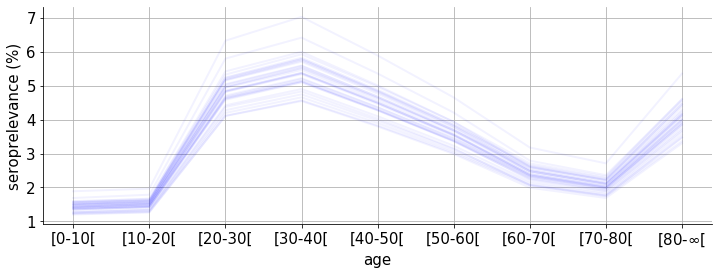

In [60]:
fig,ax=plt.subplots()
for i in range(30):
    model.parameters['beta'] = np.random.choice(samples_dict['beta'],1,replace=False)
    idx,model.parameters['l'] = random.choice(list(enumerate(samples_dict['l'])))
    model.parameters['tau'] = samples_dict['tau'][idx]
    prevention = samples_dict['prevention'][idx]
    # Create a dictionary of past policies
    chk = {'time':   [lag_time,lag_time+50,lag_time+52,lag_time+57,lag_time+64,lag_time+81,lag_time+108], 
          'Nc':      [prevention*(1.0*Nc_home + (1-0.60)*Nc_work + (1-0.70)*Nc_transport + (1-0.30)*Nc_others + (1-0.80)*Nc_leisure),
                      prevention*(1.0*Nc_home + (1-0.50)*Nc_work + (1-0.60)*Nc_transport + (1-0.30)*Nc_others + (1-0.70)*Nc_leisure),
                      prevention*(1.0*Nc_home + (1-0.40)*Nc_work + (1-0.55)*Nc_transport + (1-0.25)*Nc_others + (1-0.65)*Nc_leisure),
                      prevention*(1.0*Nc_home + (1-0.30)*Nc_work + (1-0.50)*Nc_transport + (1-0.20)*Nc_others + (1-0.60)*Nc_leisure),
                      prevention*(1.0*Nc_home + (1-0.30)*Nc_work + (1-0.45)*Nc_transport + (1-0.85)*Nc_schools + (1-0.15)*Nc_others + (1-0.50)*Nc_leisure),
                      prevention*(1.0*Nc_home + (1-0.25)*Nc_work + (1-0.35)*Nc_transport + (1-0.35)*Nc_schools + (1-0.10)*Nc_others + (1-0.30)*Nc_leisure),
                      prevention*(1.0*Nc_home + (1-0.20)*Nc_work + (1-0.15)*Nc_transport + (1-0.00)*Nc_others + (1-0.00)*Nc_leisure)]
                  }
    y_model = model.sim(data[0].size+lag_time-1+T,checkpoints=chk)
    ax.plot((1-y_model["S"][:,lag_time+36]/y_model["S"][:,0])*100,alpha=0.05,color='blue',linewidth=2)
ax.set_xlabel('age')
ax.set_ylabel("seroprelevance (%)" )
plt.xticks(np.arange(9), ('[0-10[', '[10-20[', '[20-30[', '[30-40[', '[40-50[', '[50-60[', '[60-70[', '[70-80[', '[80-$\infty$['))
fig.set_size_inches(12, 4)

#### Basic reproduction number vs expected hospitalisations

1.6371595958661558 1.6211233209819833 1.6529686492377154
2.0056305846013673 1.9859850696179884 2.0249977379538295
4.414393932051874 4.371154143627976 4.457021046385204
5.177462245653499 5.126748064834861 5.227457846068659
4.068346953429086 4.028496757862258 4.107632502793474
2.9883170100032928 2.959045903426717 3.0171733678205563
1.4771816171230114 1.4627123555275965 1.4914458605624112
0.8366881225845482 0.8284926108213906 0.844767510335558
0.9272265339806824 0.9181441820729287 0.9361801960428541


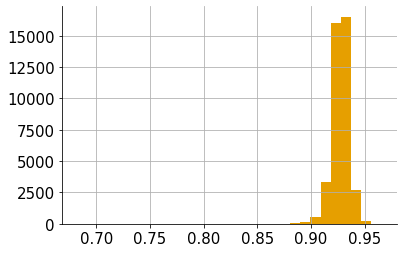

In [9]:
R_0 = np.zeros([initN.size,len(samples_dict['beta'])])
for i in range(len(samples_dict['beta'])):
    R_0[:,i]= (model.parameters['a']*model.parameters['da']+model.parameters['omega'])*samples_dict['beta'][i]*model.parameters['s']*np.sum(Nc_total,axis=1)
plt.hist(R_0[8,:],bins=30)

means=np.zeros(R_0.shape[0])
for i in range(R_0.shape[0]):
    mean = np.mean(R_0[i,:])
    means[i]=mean
    p10 = np.percentile(R_0[i,:],10)
    p90 = np.percentile(R_0[i,:],90)
    print(mean,p10,p90)

[ 0.03205377  0.07242297  1.2917763   5.02354072  7.94649576 16.85040115
 20.1708144  18.65322859 29.95926634]


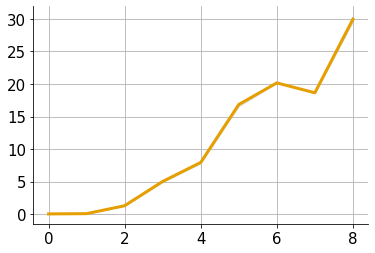

In [13]:
# define dataset
data=[df_sciensano["H_in"].values[:51]]
states = [["H_in"]]
start_date = '15-03-2020'

T = 2

fig,ax=plt.subplots()
n=300
csum_save=np.zeros([n,9])
for i in range(n):
    model.parameters['beta'] = np.random.choice(samples_dict['beta'],1,replace=False)
    idx,model.parameters['l'] = random.choice(list(enumerate(samples_dict['l'])))
    model.parameters['tau'] = samples_dict['tau'][idx]
    prevention = samples_dict['prevention'][idx]
    # Create a dictionary of past policies
    chk = {'time':   [lag_time], 
          'Nc':      [prevention*(1.0*Nc_home + (1-0.60)*Nc_work + (1-0.70)*Nc_transport + (1-0.30)*Nc_others + (1-0.80)*Nc_leisure)]
          }
    y_model = model.sim(data[0].size+lag_time-1+T,checkpoints=chk)
    
    # Create shifted index vector 
    idx = pd.date_range(start_date,freq='D',periods=data[0].size + lag_time + T) - datetime.timedelta(days=lag_time)

    # ages i plus
    data2plot = y_model[states[0]].to_array(dim="states").values.ravel()
    val = y_model[states[0]].to_array(dim="states").values[-1,:,:].sum(axis=1)
    #csum_iplus=np.cumsum(val)
    csum_iplus=val
    csum_save[i,:]=np.reshape((csum_iplus/sum(csum_iplus)),(1,(csum_iplus/sum(csum_iplus)).size))*100
    #csum_save[i,:] = csum_iplus/csum_iplus[-1]
print(csum_save.mean(axis=0))
csum_hosp_mean = csum_save.mean(axis=0)
csum_hosp_p10 = np.percentile(csum_save,10,axis=0)
csum_hosp_p90 = np.percentile(csum_save,90,axis=0)
plt.plot(np.arange(9),csum_hosp_mean)
plt.fill_between(np.arange(9),csum_hosp_p10,csum_hosp_p90,color='black',alpha=0.1)

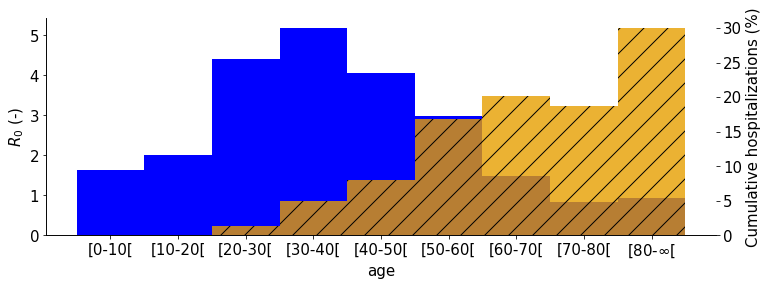

In [27]:
fig,ax1=plt.subplots()

ax1.bar(np.arange(R_0.shape[0]),means,1,color='blue')
ax1.set_xlabel('age')
ax1.set_ylabel('$R_0$ (-)')
ax1.grid(False)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.bar(np.arange(R_0.shape[0]),csum_hosp_mean,1,alpha=0.8,hatch="/")
#ax2.plot(np.arange(R_0.shape[0]),csum_hosp_mean,'-s',markerSize=12)
ax2.set_xlabel('age')
ax2.set_ylabel('Cumulative hospitalizations (%)')
ax2.grid(False)
plt.xticks(np.arange(9), ('[0-10[', '[10-20[', '[20-30[', '[30-40[', '[40-50[', '[50-60[', '[60-70[', '[70-80[', '[80-$\infty$['))
fig.set_size_inches(12, 4)
plt.savefig('R_naught_cumulative_hospitalisations.pdf', dpi=300, bbox_inches='tight',orientation='portrait', papertype='a4')

### Re-estimating beta

In [12]:
samples_dict.keys()

dict_keys(['lag_time', 'beta', 'l', 'tau', 'prevention'])

In [6]:
T = 62
from copy import deepcopy
# Create checkpoints dictionary
# checkpoints are hardcoded!
# Create a dictionary of past policies
chk = {'time':   [lag_time,lag_time+50,lag_time+52,lag_time+57,lag_time+64,lag_time+81,lag_time+108], 
        'Nc':    [prevention*(1.0*Nc_home + (1-0.60)*Nc_work + (1-0.70)*Nc_transport + (1-0.30)*Nc_others + (1-0.80)*Nc_leisure),
                  prevention*(1.0*Nc_home + (1-0.50)*Nc_work + (1-0.60)*Nc_transport + (1-0.30)*Nc_others + (1-0.70)*Nc_leisure),
                  prevention*(1.0*Nc_home + (1-0.40)*Nc_work + (1-0.55)*Nc_transport + (1-0.25)*Nc_others + (1-0.65)*Nc_leisure),
                  prevention*(1.0*Nc_home + (1-0.30)*Nc_work + (1-0.50)*Nc_transport + (1-0.20)*Nc_others + (1-0.60)*Nc_leisure),
                  prevention*(1.0*Nc_home + (1-0.30)*Nc_work + (1-0.45)*Nc_transport + (1-0.85)*Nc_schools + (1-0.15)*Nc_others + (1-0.50)*Nc_leisure),
                  prevention*(1.0*Nc_home + (1-0.25)*Nc_work + (1-0.35)*Nc_transport + (1-0.35)*Nc_schools + (1-0.10)*Nc_others + (1-0.30)*Nc_leisure),
                  prevention*(1.0*Nc_home + (1-0.20)*Nc_work + (1-0.15)*Nc_transport + (1-0.00)*Nc_others + (1-0.00)*Nc_leisure)],
        'beta': [np.random.choice(samples_dict['beta'],1,replace=False),
                   0.01,
                   0.01,
                   0.01,
                   0.01,
                   0.01,
                   0.01,]
      }


# define dataset
data=[df_sciensano["H_in"].values[50:]]
# Redine lag_time
model.extraTime = lag_time+50
# define samples_dict without lag_time
smpls=deepcopy(samples_dict)
del smpls['lag_time']
# set optimisation settings
parNames = ['sigma_H_in','beta'] # must be a list!
states = [["H_in"]]
bounds=((1,500),(0.001,0.04)) # must be a list!

In [7]:
# run optimisation
theta = MCMC.fit_pso(model,data,parNames,states,bounds,checkpoints=chk,samples=smpls,maxiter=50,popsize=20)

No constraints given.
Best after iteration 1: [1.66095352e+01 1.08097513e-02] 227.5759685714227
Best after iteration 2: [1.66095352e+01 1.08097513e-02] 227.5759685714227
Best after iteration 3: [1.66095352e+01 1.08097513e-02] 227.5759685714227
Best after iteration 4: [1.66095352e+01 1.08097513e-02] 227.5759685714227
New best for swarm at iteration 5: [1.03903371e+01 8.26991980e-03] 214.5108208326445
Best after iteration 5: [1.03903371e+01 8.26991980e-03] 214.5108208326445
New best for swarm at iteration 6: [1.34931086e+01 9.02748568e-03] 207.02023950901412
Best after iteration 6: [1.34931086e+01 9.02748568e-03] 207.02023950901412
Best after iteration 7: [1.34931086e+01 9.02748568e-03] 207.02023950901412
New best for swarm at iteration 8: [1.38339475e+01 1.14140455e-02] 201.60614558085723
Best after iteration 8: [1.38339475e+01 1.14140455e-02] 201.60614558085723
Best after iteration 9: [1.38339475e+01 1.14140455e-02] 201.60614558085723
New best for swarm at iteration 10: [12.15872595  0

In [8]:
parNames = ['sigma_ICU','beta'] # must be a list!
bounds=((1,200),(0.0001,0.10))

pos = [theta[0],theta[1]] + [1, 1e-2 ]* np.random.randn(8, 2)
nwalkers, ndim = pos.shape
sampler = emcee.EnsembleSampler(nwalkers, ndim, objective_fcns.log_probability,
                                args=(model,bounds,data,states,parNames,chk,smpls))
sampler.run_mcmc(pos, 12000, progress=True);

  0%|          | 0/12000 [00:00<?, ?it/s]/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 12000/12000 [4:37:45<00:00,  1.39s/it] 


In [10]:
samples = sampler.get_chain(discard=500,flat=False)
flat_samples = sampler.get_chain(discard=500,flat=True)

In [9]:
sampler.get_autocorr_time()

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 240;
tau: [650.19011597 527.66411203]

In [13]:
mean = np.mean(flat_samples[:,1])
p10 = np.percentile(flat_samples[:,1],10)
p90 = np.percentile(flat_samples[:,1],90)
print(mean,p10,p90)

0.010387174250515432 0.009751388541836364 0.0111088400688214


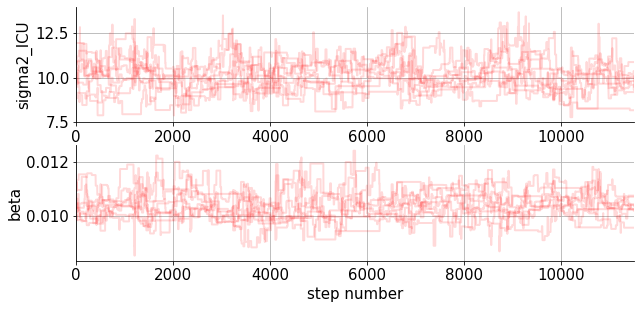

In [11]:
traceplot(samples,labels=["sigma2_ICU","beta"],plt_kwargs={'linewidth':2,'color': 'red','alpha': 0.15})

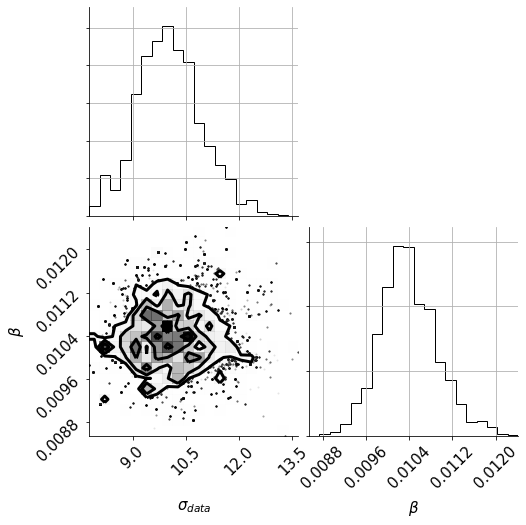

In [12]:
import corner

fig = corner.corner(
    flat_samples,labels=['$\sigma_{data}$','$\\beta$']
);
fig.set_size_inches(8, 8)
plt.savefig('corner_beta.pdf', dpi=600, bbox_inches='tight',
                    orientation='portrait', papertype='a4')

In [8]:
# define dataset
data=[df_sciensano["H_tot"].values[:],df_sciensano["ICU_tot"].values[:]]
states = [["H_tot"],["ICU"]]

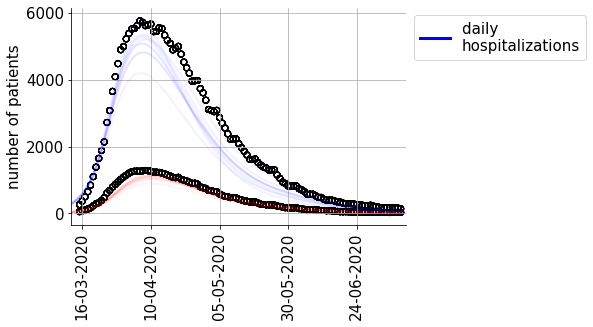

In [10]:
T = 1
start_date='15-03-2020'
#data=[df_sciensano["H_in"].values[:]]

fig,ax=plt.subplots()
for i in range(10):
    model.parameters['beta'] = np.random.choice(samples_dict['beta'],1,replace=False)
    idx,model.parameters['l'] = random.choice(list(enumerate(samples_dict['l'])))
    model.parameters['tau'] = samples_dict['tau'][idx]
    prevention = samples_dict['prevention'][idx]
    # Create a dictionary of past policies
    chk = {'time':   [lag_time,lag_time+50,lag_time+52,lag_time+57,lag_time+64,lag_time+81,lag_time+108], 
            'Nc':    [prevention*(1.0*Nc_home + (1-0.60)*Nc_work + (1-0.70)*Nc_transport + (1-0.30)*Nc_others + (1-0.80)*Nc_leisure),
                      prevention*(1.0*Nc_home + (1-0.50)*Nc_work + (1-0.60)*Nc_transport + (1-0.30)*Nc_others + (1-0.70)*Nc_leisure),
                      prevention*(1.0*Nc_home + (1-0.40)*Nc_work + (1-0.55)*Nc_transport + (1-0.25)*Nc_others + (1-0.65)*Nc_leisure),
                      prevention*(1.0*Nc_home + (1-0.30)*Nc_work + (1-0.50)*Nc_transport + (1-0.20)*Nc_others + (1-0.60)*Nc_leisure),
                      prevention*(1.0*Nc_home + (1-0.30)*Nc_work + (1-0.45)*Nc_transport + (1-0.85)*Nc_schools + (1-0.15)*Nc_others + (1-0.50)*Nc_leisure),
                      prevention*(1.0*Nc_home + (1-0.25)*Nc_work + (1-0.35)*Nc_transport + (1-0.35)*Nc_schools + (1-0.10)*Nc_others + (1-0.30)*Nc_leisure),
                      prevention*(1.0*Nc_home + (1-0.20)*Nc_work + (1-0.15)*Nc_transport + (1-0.00)*Nc_others + (1-0.00)*Nc_leisure)],
            'beta': [np.random.choice(samples_dict['beta'],1,replace=False),
                       theta[1],
                       theta[1],
                       theta[1],
                       theta[1],
                       theta[1],
                       theta[1]
                    ]
          }
    y_model = model.sim(data[0].size+lag_time-1+T,checkpoints=chk)
    ax = plot_fit(y_model,data,start_date,lag_time,states,T=T,ax=ax,plt_kwargs={'linewidth': 2,'alpha': 0.05})
    
#plt.scatter(pd.date_range('15-03-2020',freq='D',periods=df_sciensano["H_in"][:50].size),df_sciensano["H_in"][:50], marker='o',color='red',linestyle='None',facecolors='none')
legend_text=['daily \nhospitalizations']
leg=ax.legend(legend_text, loc="upper left", bbox_to_anchor=(1,1))
plt.savefig('plot_fit_beta.pdf', dpi=600, bbox_inches='tight',orientation='portrait', papertype='a4')

#### Re-compute the basic reproduction number

In [14]:
R_0 = (model.parameters['a']*model.parameters['da']+model.parameters['omega'])*mean*model.parameters['s']*np.sum(Nc_total,axis=1)

In [15]:
print(R_0,np.mean(R_0))

[0.46247307 0.56656061 1.24700018 1.46255555 1.14924709 0.8441548
 0.41728169 0.23635187 0.26192761] 0.7386169401314516
